# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering` and `DBSCAN`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
X_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
delimiter = ','
X0 = pd.read_csv(X_url, delimiter=delimiter)
X0.shape

(440, 8)

In [3]:
X0.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

## 2. Observe the data distributions

{'whiskers': [<matplotlib.lines.Line2D at 0x2080ab23c10>,
 'caps': [<matplotlib.lines.Line2D at 0x2083c80dc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2083c7ff650>,
 'medians': [<matplotlib.lines.Line2D at 0x2083c80f2d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2083c80fe10>,
 'means': []}

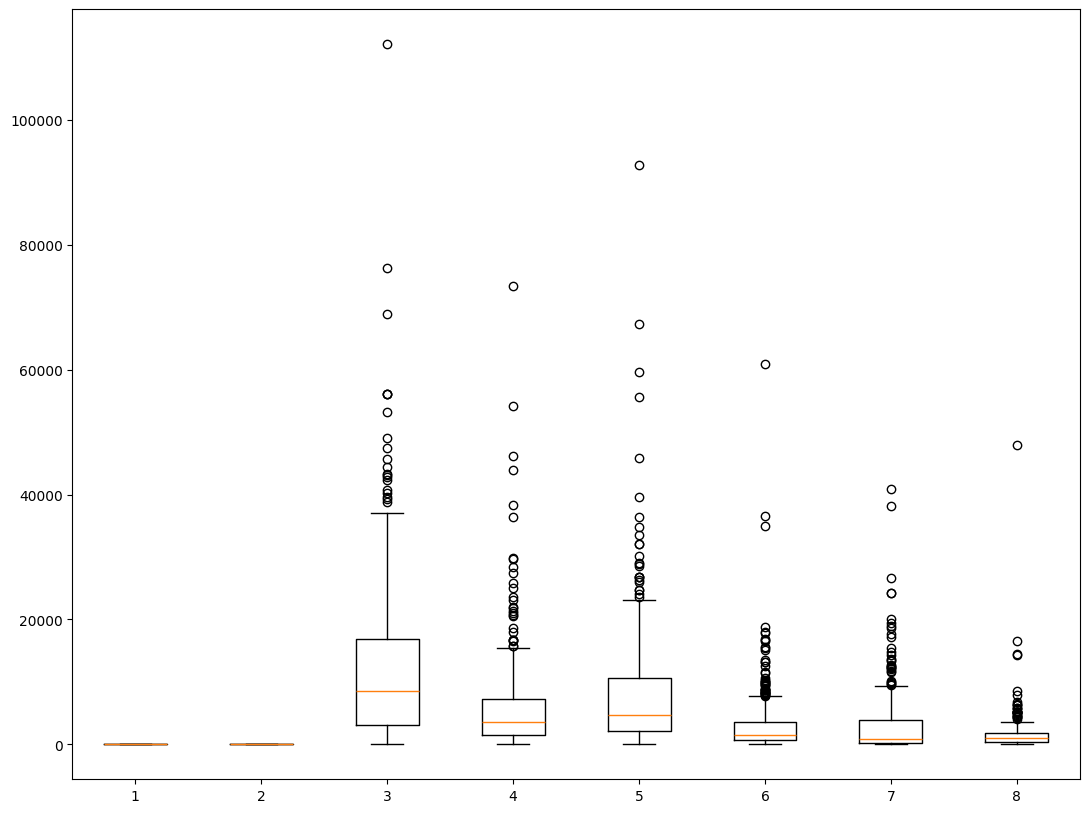

In [4]:
plt.figure(figsize=(13,10))
plt.boxplot(X0)

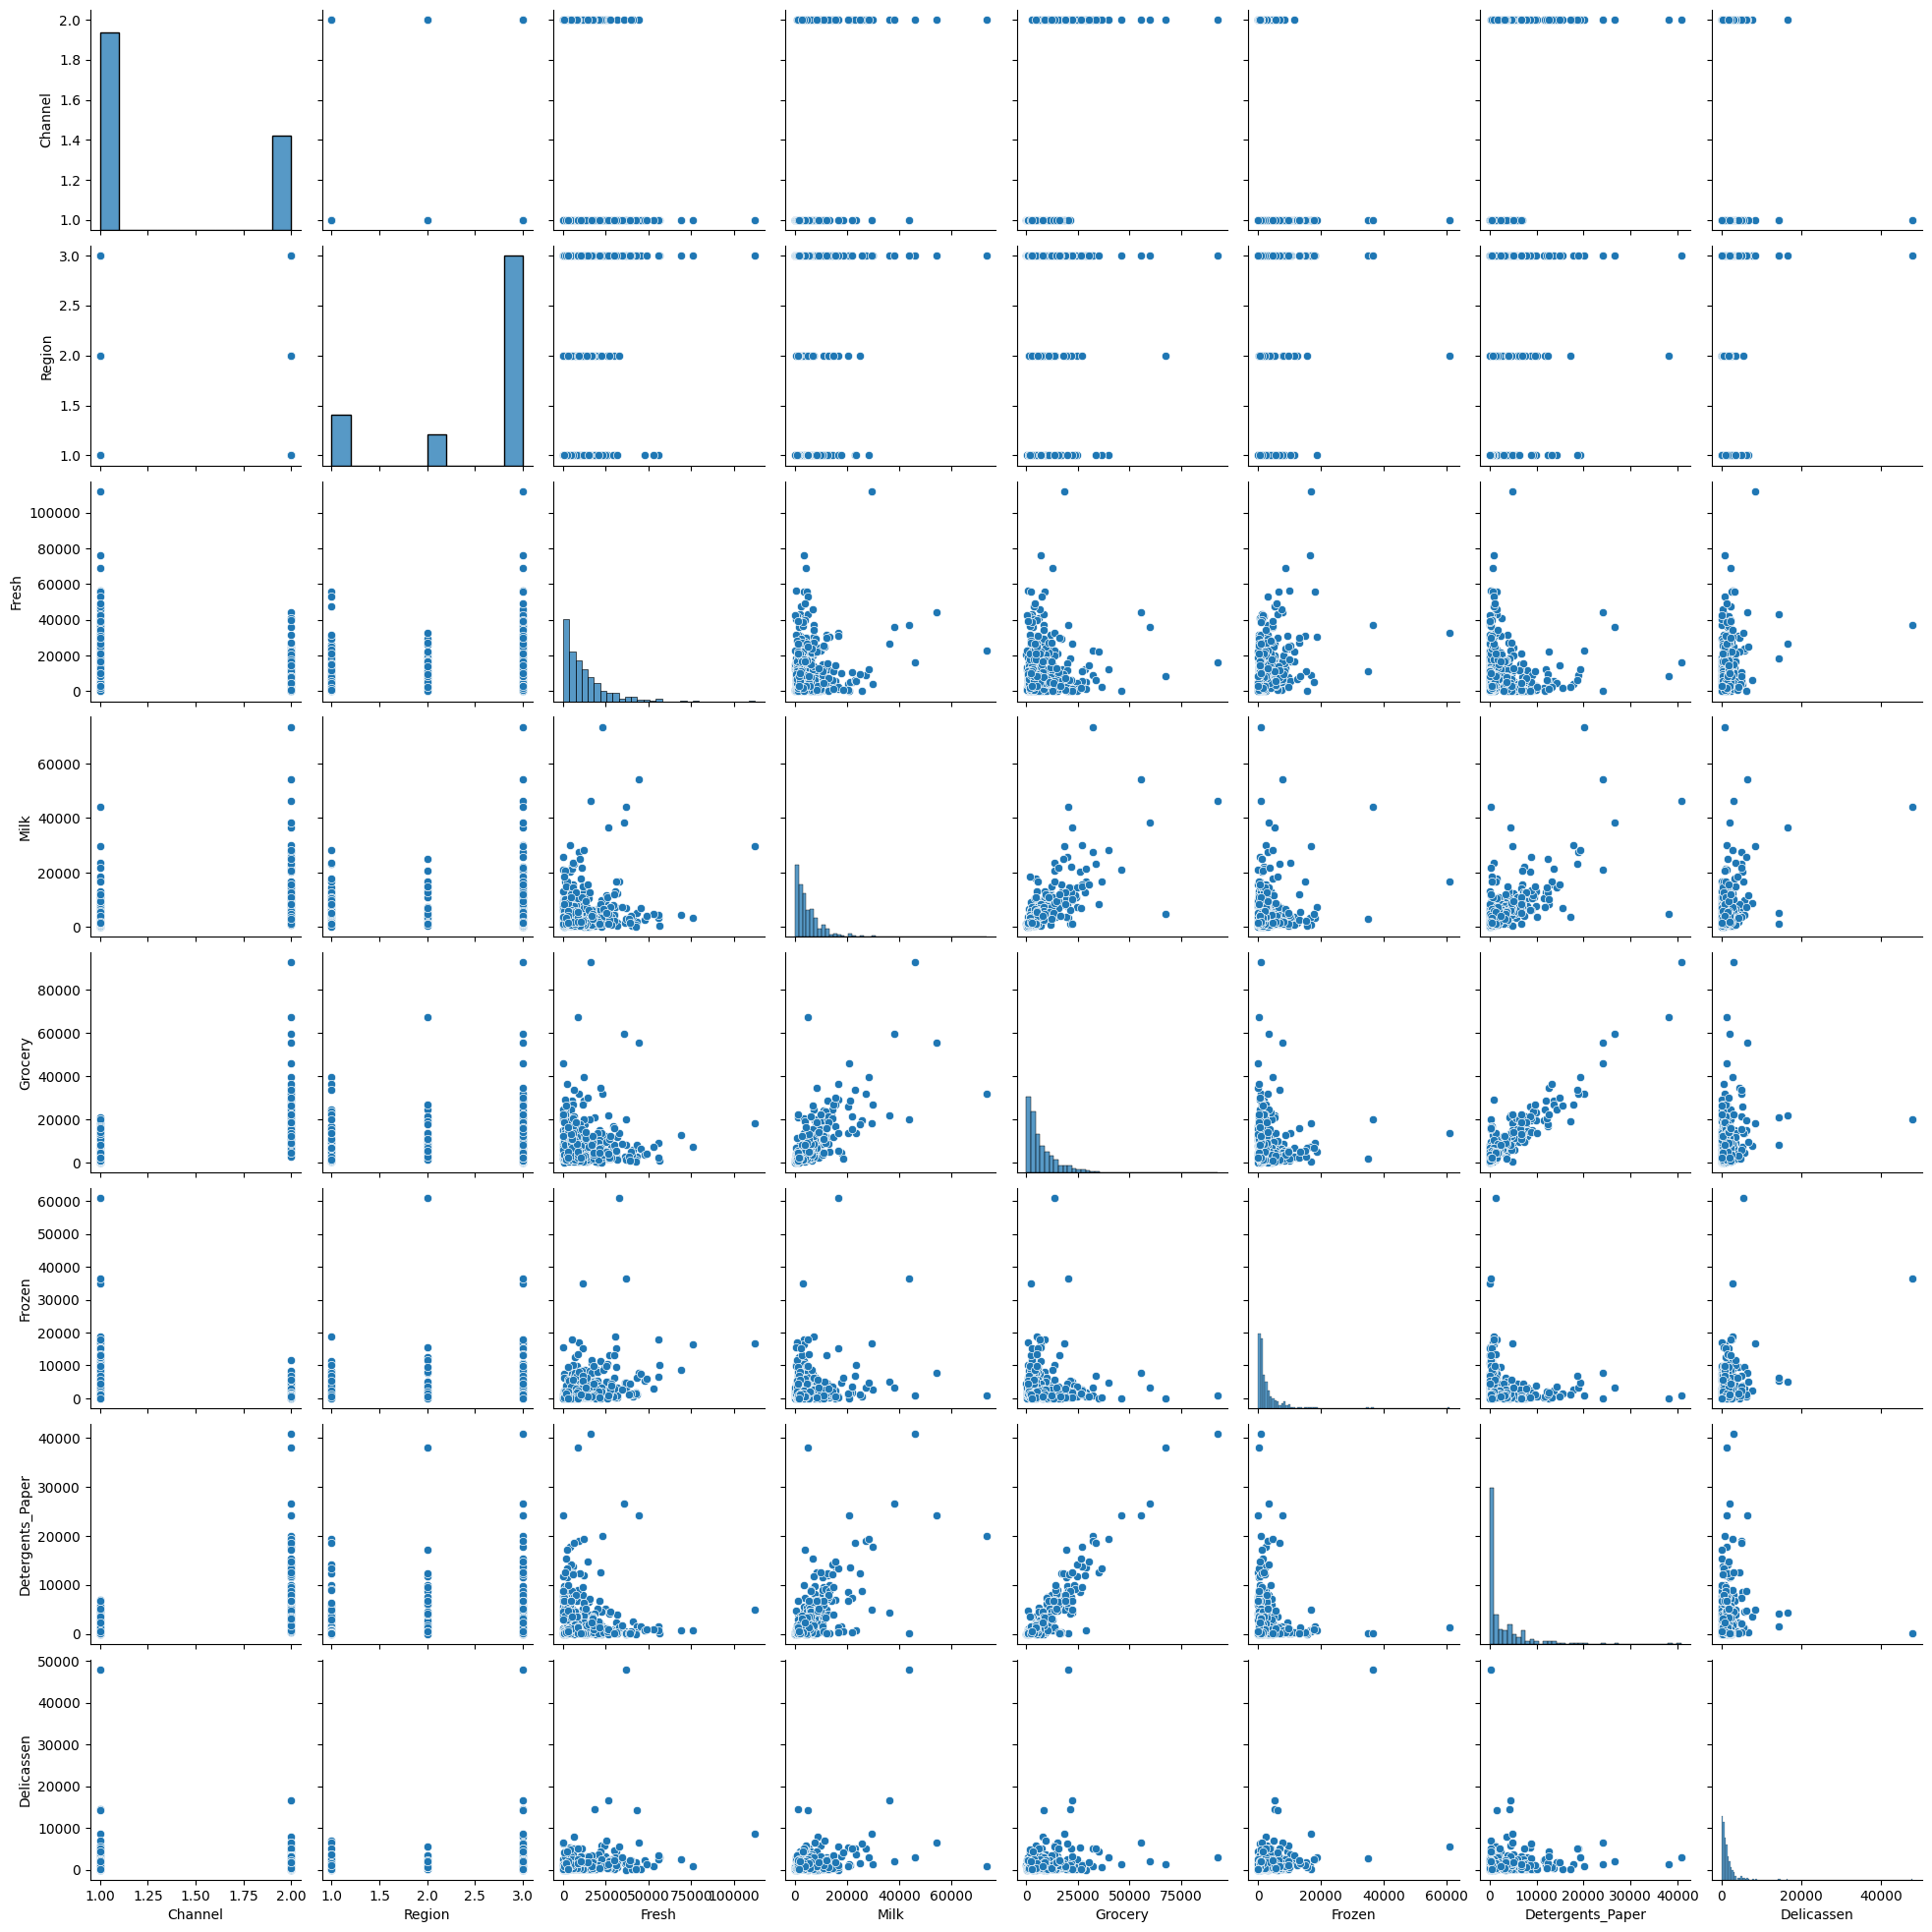

In [5]:
sns.pairplot(X0)

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1`

In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

# pt = PowerTransformer()
# X_pt = pd.DataFrame(pt.fit_transform(X0.iloc[:,2:]),columns=X0.columns[2:])
# X_trasf = pd.concat([X0.iloc[:,:2],X_pt],axis=1)

# mms = MinMaxScaler()
# X = pd.DataFrame(mms.fit_transform(X_trasf), columns = X_trasf.columns)
# X.head()

pt = PowerTransformer()
X_pt = pd.DataFrame(pt.fit_transform(X0.iloc[:, 2:]), columns=X0.columns[2:])
X_transf = pd.concat([X0.iloc[:, :2], X_pt], axis=1)
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X_transf), columns=X_transf.columns)
X.head()

Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0      1.0     1.0  0.501828  0.667606  0.625238  0.208640          0.649941   
1      1.0     1.0  0.414266  0.670028  0.655690  0.458800          0.674852   
2      1.0     1.0  0.400077  0.653586  0.627297  0.499856          0.682752   
3      0.0     1.0  0.509368  0.369264  0.553550  0.636716          0.461095   
4      1.0     1.0  0.604755  0.580657  0.618985  0.566470          0.601884   

   Delicassen  
0    0.412016  
1    0.445663  
2    0.654292  
3    0.446485  
4    0.590255

Show the result of the transformation

{'whiskers': [<matplotlib.lines.Line2D at 0x208428d1210>,
 'caps': [<matplotlib.lines.Line2D at 0x208428d2650>,
 'boxes': [<matplotlib.lines.Line2D at 0x208428d0910>,
 'medians': [<matplotlib.lines.Line2D at 0x208428d38d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x208428e01d0>,
 'means': []}

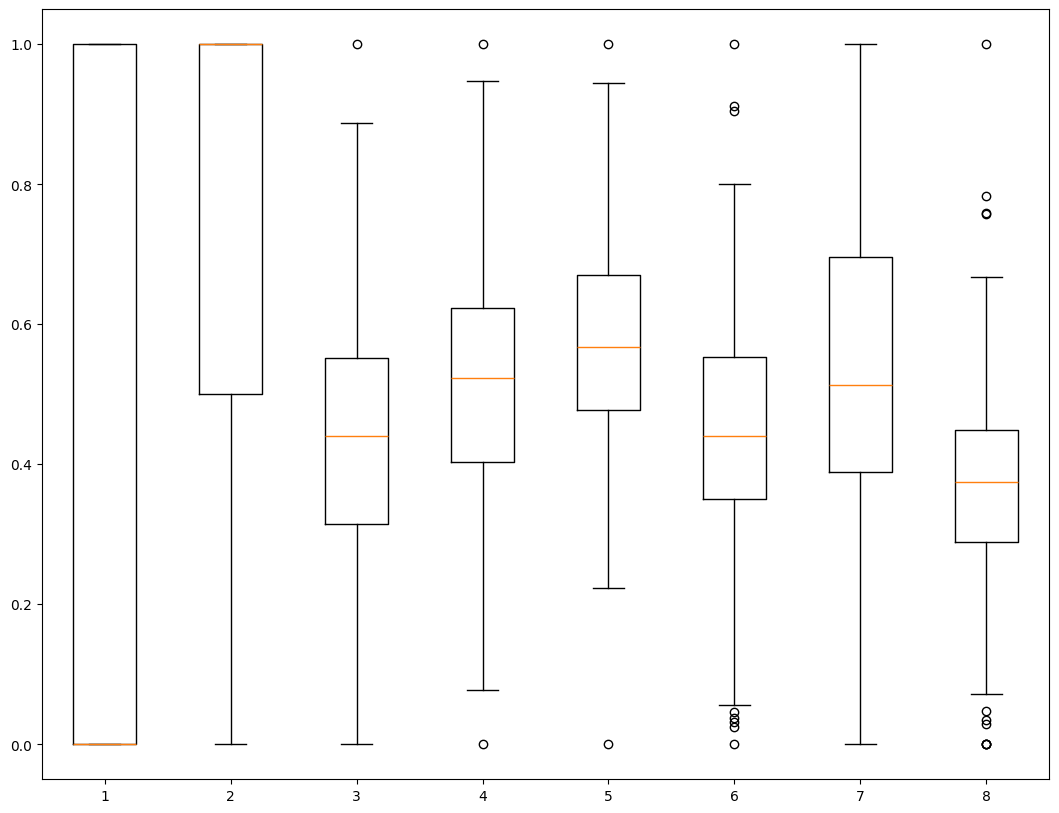

In [7]:
plt.figure(figsize=(13,10))
plt.boxplot(X)

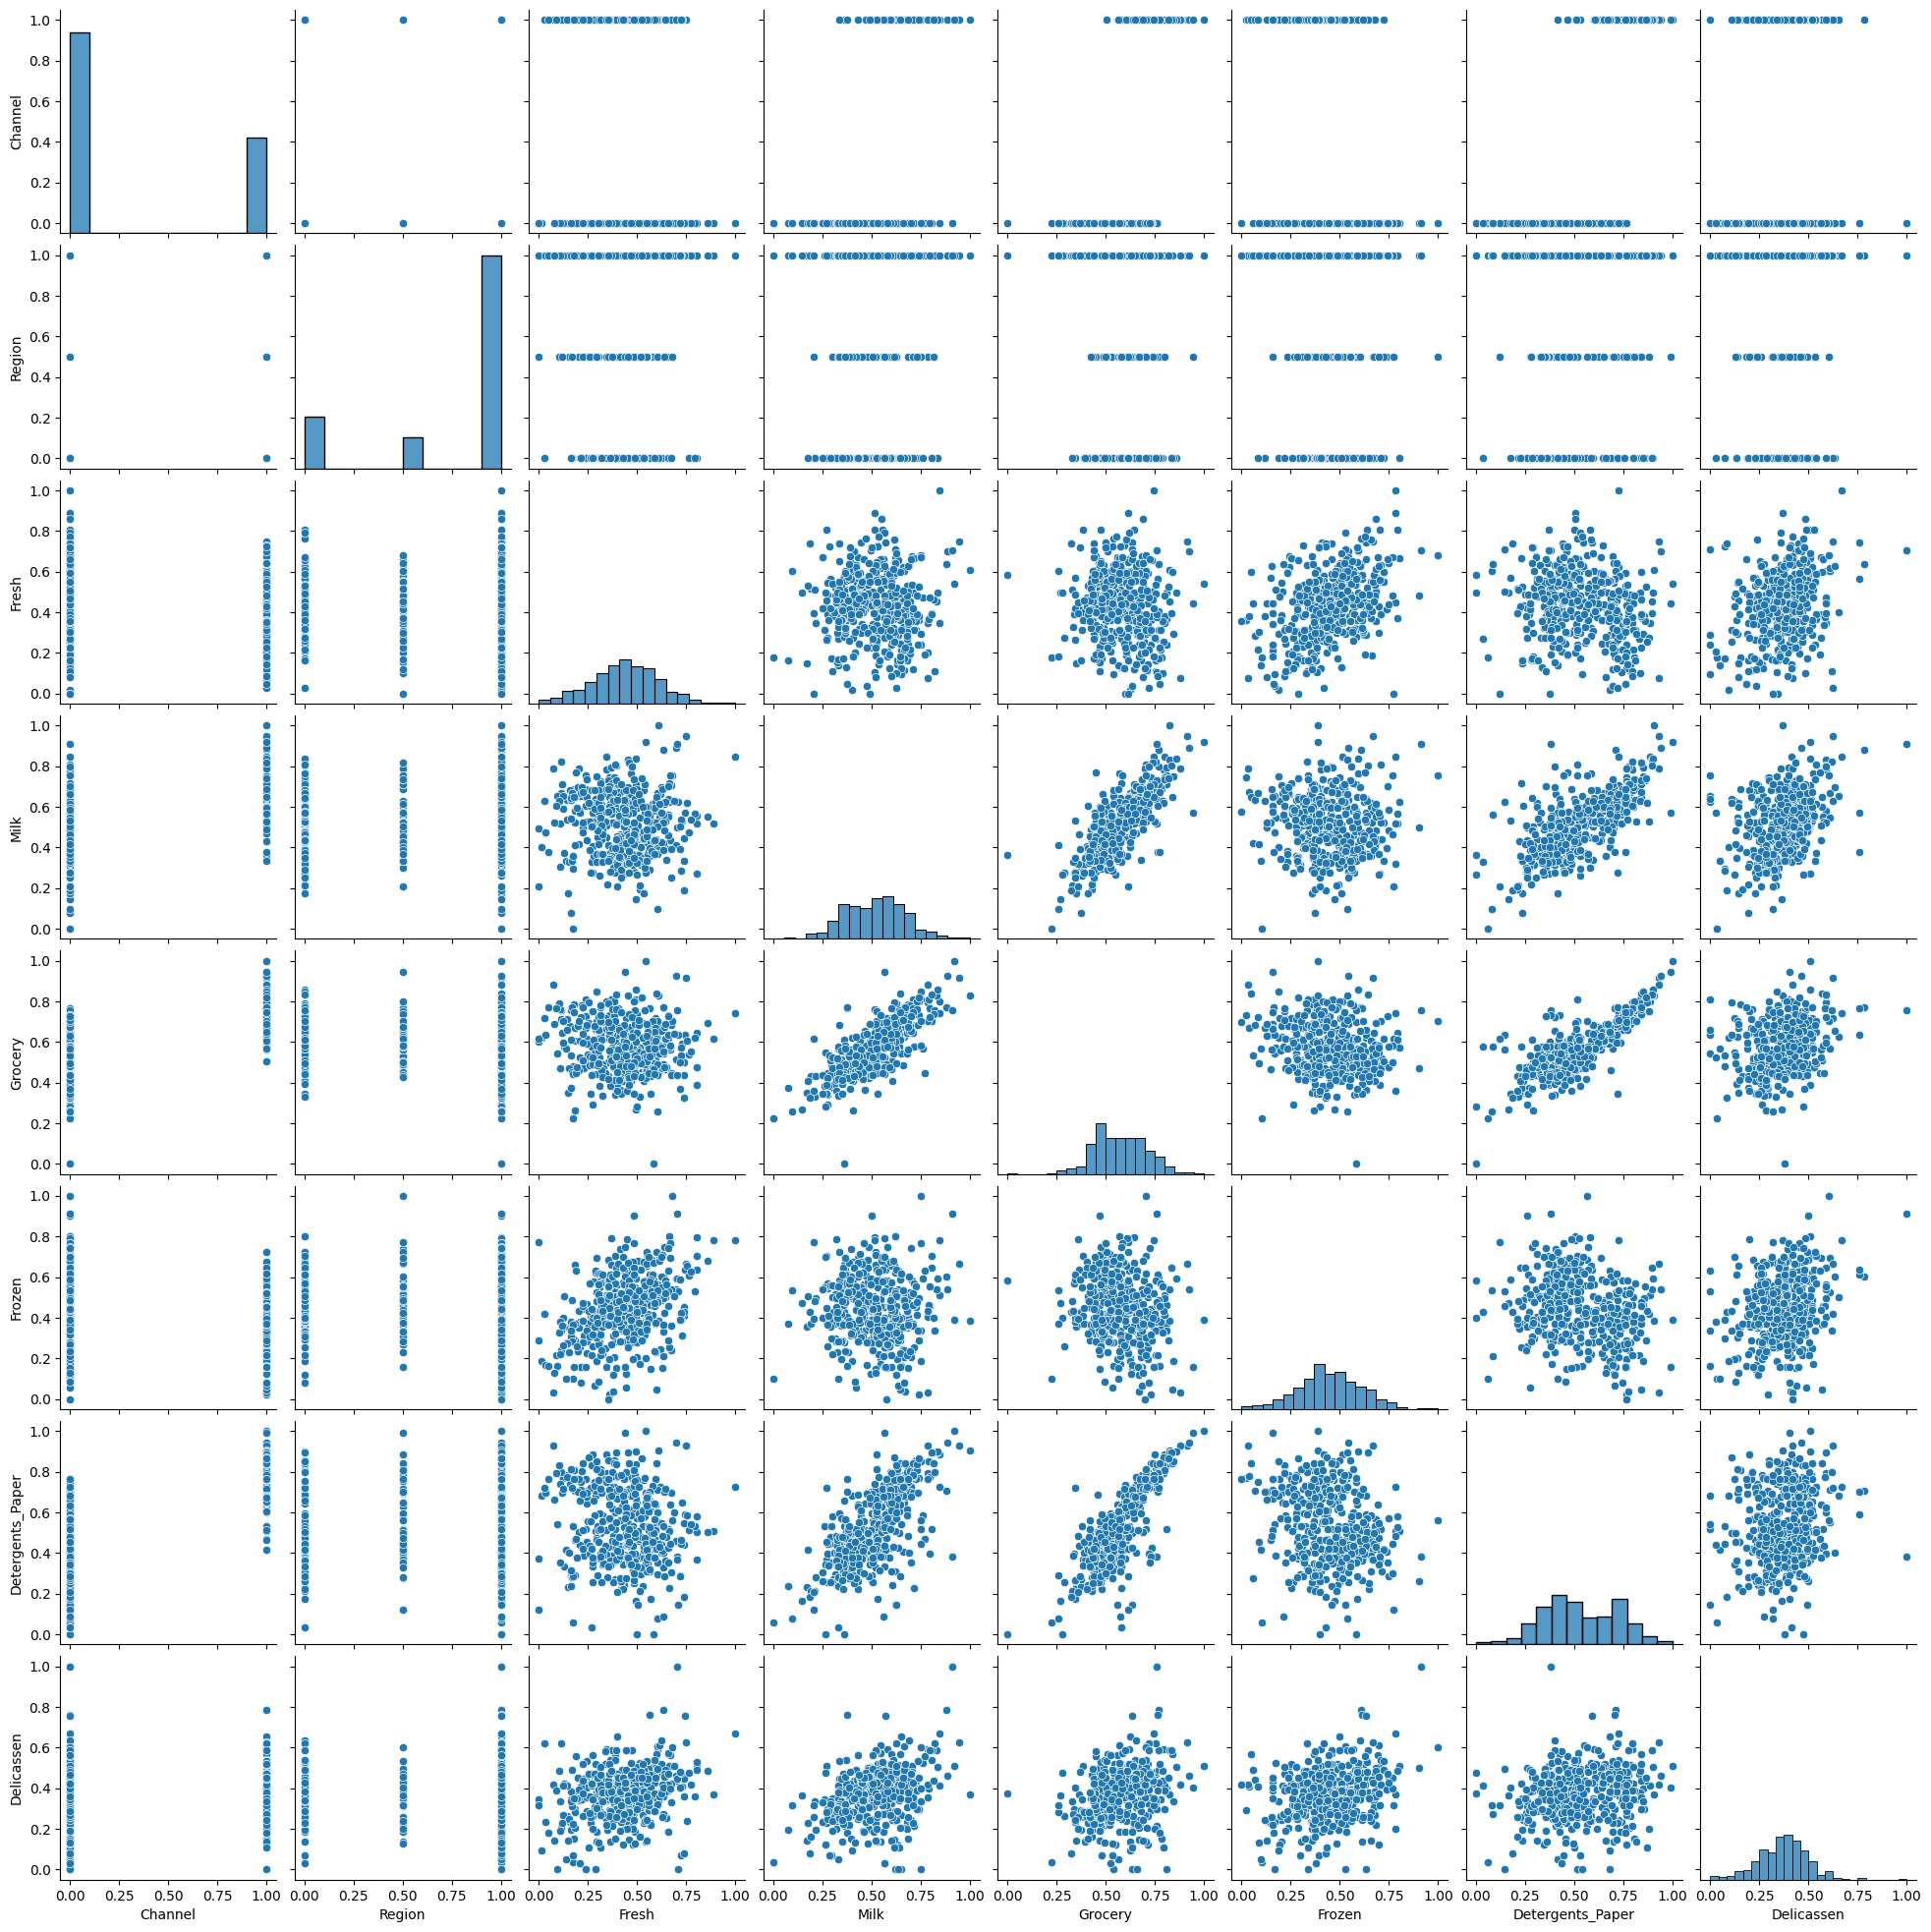

In [8]:
sns.pairplot(X)

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [9]:
#you always have to declare the parameters, which needs to be of course done outside the function
#1) define the range
#2) define the dictionary of parameters
#3) define the parameter grid
#4) define the arrays as needed
#5) loop on the len of the param grid
#6) define the clustering mechanism
#7) predict y
#8) add everything where it needs to be
k_range = list(range(2, 11))
param = [{
    'n_clusters': k_range
}]
pg = ParameterGrid(list(param))
inertias = []
silhouette = []
for i in range(len(pg)):
    km = KMeans(**pg[i], random_state=random_state)
    y_km = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouette.append(silhouette_score(X, y_km))

In [10]:
# k_range = list(range(2,11))
# parameters_km = [{'n_clusters': k_range}]
# pg = ParameterGrid(list(parameters_km))
# inertias_km = []
# silhouette_scores = []
# for i in range(len(pg)):
#     km = KMeans(**pg[i], random_state=random_state)
#     y_km = km.fit_predict(X)
#     inertias_km.append(km.inertia_)
#     silhouette_scores.append(silhouette_score(X,y_km))



#how to teas KMeans with varying number of clusters

#first you have to define the range of k, from 2 to 10
k_range = list(range(2,11))
#you also need a parameters dictionary for KMeans, you need to define the number of clusters that needs to be equal to k_range
parameters_km = [{'n_clusters': k_range}]
#then you need to define the parameter grid
pg = ParameterGrid(list(parameters_km))
#define inertias and silhouette_scores that will contain the results
inertias_km = []
silhouette_scores_km = []

#now for each value of k you have to
for k in range(len(pg)):
    #initialize kmeans estimator, **parameter_grid[k]
    km = KMeans(**pg[k], random_state=random_state)
    #fit and predict
    y_km = km.fit_predict(X)
    #append the inertias and silhouette scores
    inertias_km.append(km.inertia_)
    silhouette_scores_km.append(silhouette_score(X, y_km))


## 4. Plot __inertia__ and __silhouette score__ versus `k`

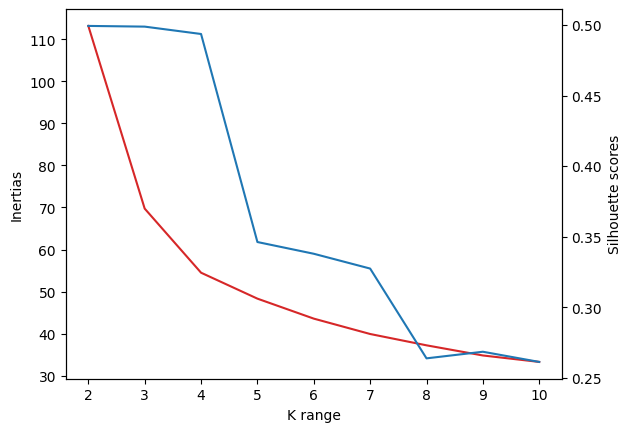

In [10]:
# x = k_range
# y1 = inertias_km
# y2 = silhouette_scores

x = k_range
y1 = inertias
y2 = silhouette

fig, ax1 = plt.subplots()
ax1.set_xlabel('K range')
ax1.set_ylabel('Inertias')
ax1.plot(x, y1, color='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette scores')
ax2.plot(x, y2, color='tab:blue')



In [12]:
# fig, ax1 = plt.subplots()
# ax1.set_xlabel('Number of clusters')
# ax1.set_ylabel('Inertias')
# ax1.plot(x, y1, color='tab:red')
# ax2 = ax1.twinx()

# ax2.set_ylabel('Silhouettes scores')
# ax2.plot(x, y2, color='tab:blue')



## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [11]:
# k = 4
# km = KMeans(4, random_state=random_state)
# y_km = km.fit_predict(X)
# print(f'Number of clusters = {k} - Distortion = {inertias_km[k_range.index(k)]} - Silhouette score = {inertias_km[k_range.index(k)]}')

k = 4
km = KMeans(4, random_state=random_state)
y_km = km.fit_predict(X)
print(f'N clusters = {k}, distortion = {km.inertia_} and silhouette score = {silhouette_score(X, y_km)}')


N clusters = 4, distortion = 54.49187334660469 and silhouette score = 0.4936294481365849


Show the distribution of samples in the clusters with a pie chart

([<matplotlib.patches.Wedge at 0x2084868b890>,
 [Text(0.8050839839697408, 0.7495597232745436, '0'),
  Text(-0.5747484124062512, 0.9379041861706845, '1'),
  Text(-0.49237895618600735, -0.9836477842729978, '2'),
  Text(1.0618377985976803, -0.28722898438220384, '3')])

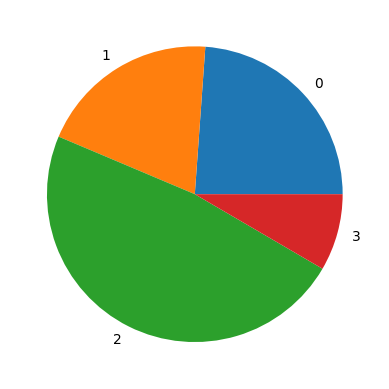

In [12]:
plt.pie(np.unique(y_km, return_counts=True)[1], labels = np.unique(y_km, return_counts=True)[0])

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [14]:
# from sklearn.cluster import AgglomerativeClustering
# parameters = [{
#     'n_clusters': k_range,
#     'linkage' : ['ward', 'complete', 'average', 'single']
# }]
# pg = list(ParameterGrid(parameters))
# result_ac = []
# for i in range(len(pg)):
#     ac = AgglomerativeClustering()
#     y_ac = ac.fit_predict(X)
#     result_ac.append([pg[i]['linkage'],pg[i]['n_clusters'],silhouette_score(X,y_ac)])


#now you should do the same thing for Agglomerative Clustering instead of KMeans

#again, let's start by defining the parameters
from sklearn.cluster import AgglomerativeClustering

k_range = list(range(2, 11))
params = [{
    'n_clusters': k_range,
    'linkage': ['ward', 'complete', 'average', 'single']
}]
pg = list(ParameterGrid(params))
results_ac =  pd.DataFrame(
    columns=['linkage', 'clusters', 'silhouette_scores']
)
for i in range(len(pg)):
    ac = AgglomerativeClustering(**pg[i])
    y_ac = ac.fit_predict(X)
    results_ac.loc[len(results_ac)] = (pg[i]['linkage'], pg[i]['n_clusters'], silhouette_score(X, y_ac))

    



In [15]:
# df_results_ac = pd.DataFrame(data = result_ac, columns=['linkage', 'n_clusters', 'silhouette_score'])
# df_results_ac.head()

results_ac.head()

linkage  clusters  silhouette_scores
0    ward         2           0.499350
1    ward         3           0.498333
2    ward         4           0.493085
3    ward         5           0.342252
4    ward         6           0.333632

The top five results have a very similar silhouette score, we will choose the setting with 4 clusters, as for k-means, and the linkage giving the best result with 4 clusters, that is `ward`. This is the result record with `index 2` (the record index is the unnamed column at the very left of the dataframe output

In [16]:
print(results_ac.loc[2])

linkage                  ward
clusters                    4
silhouette_scores    0.493085
Name: 2, dtype: object


In [17]:
# ac = AgglomerativeClustering(**pg[2])
# y_ac = ac.fit_predict(X)

#now you have to do the thing we did before for index 2
ac = AgglomerativeClustering(**pg[2])
y_ac = ac.fit_predict(X)


Show the distribution of data in the clusters

([<matplotlib.patches.Wedge at 0x20821603b10>,
 [Text(0.06279773494711323, 1.09820601186003, '0'),
  Text(-1.0876581162598185, -0.16431622602209278, '1'),
  Text(-0.5680372494949927, -0.9419839081354647, '2'),
  Text(0.8050839488803164, -0.7495597609632445, '3')])

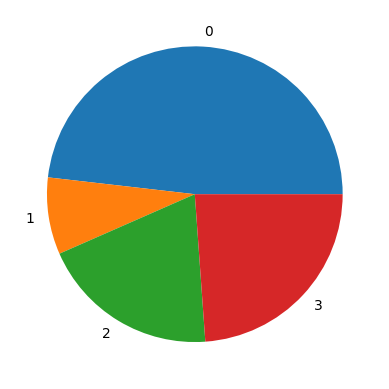

In [18]:
plt.pie(np.unique(y_ac, return_counts=True)[1], labels = np.unique(y_ac, return_counts=True)[0])

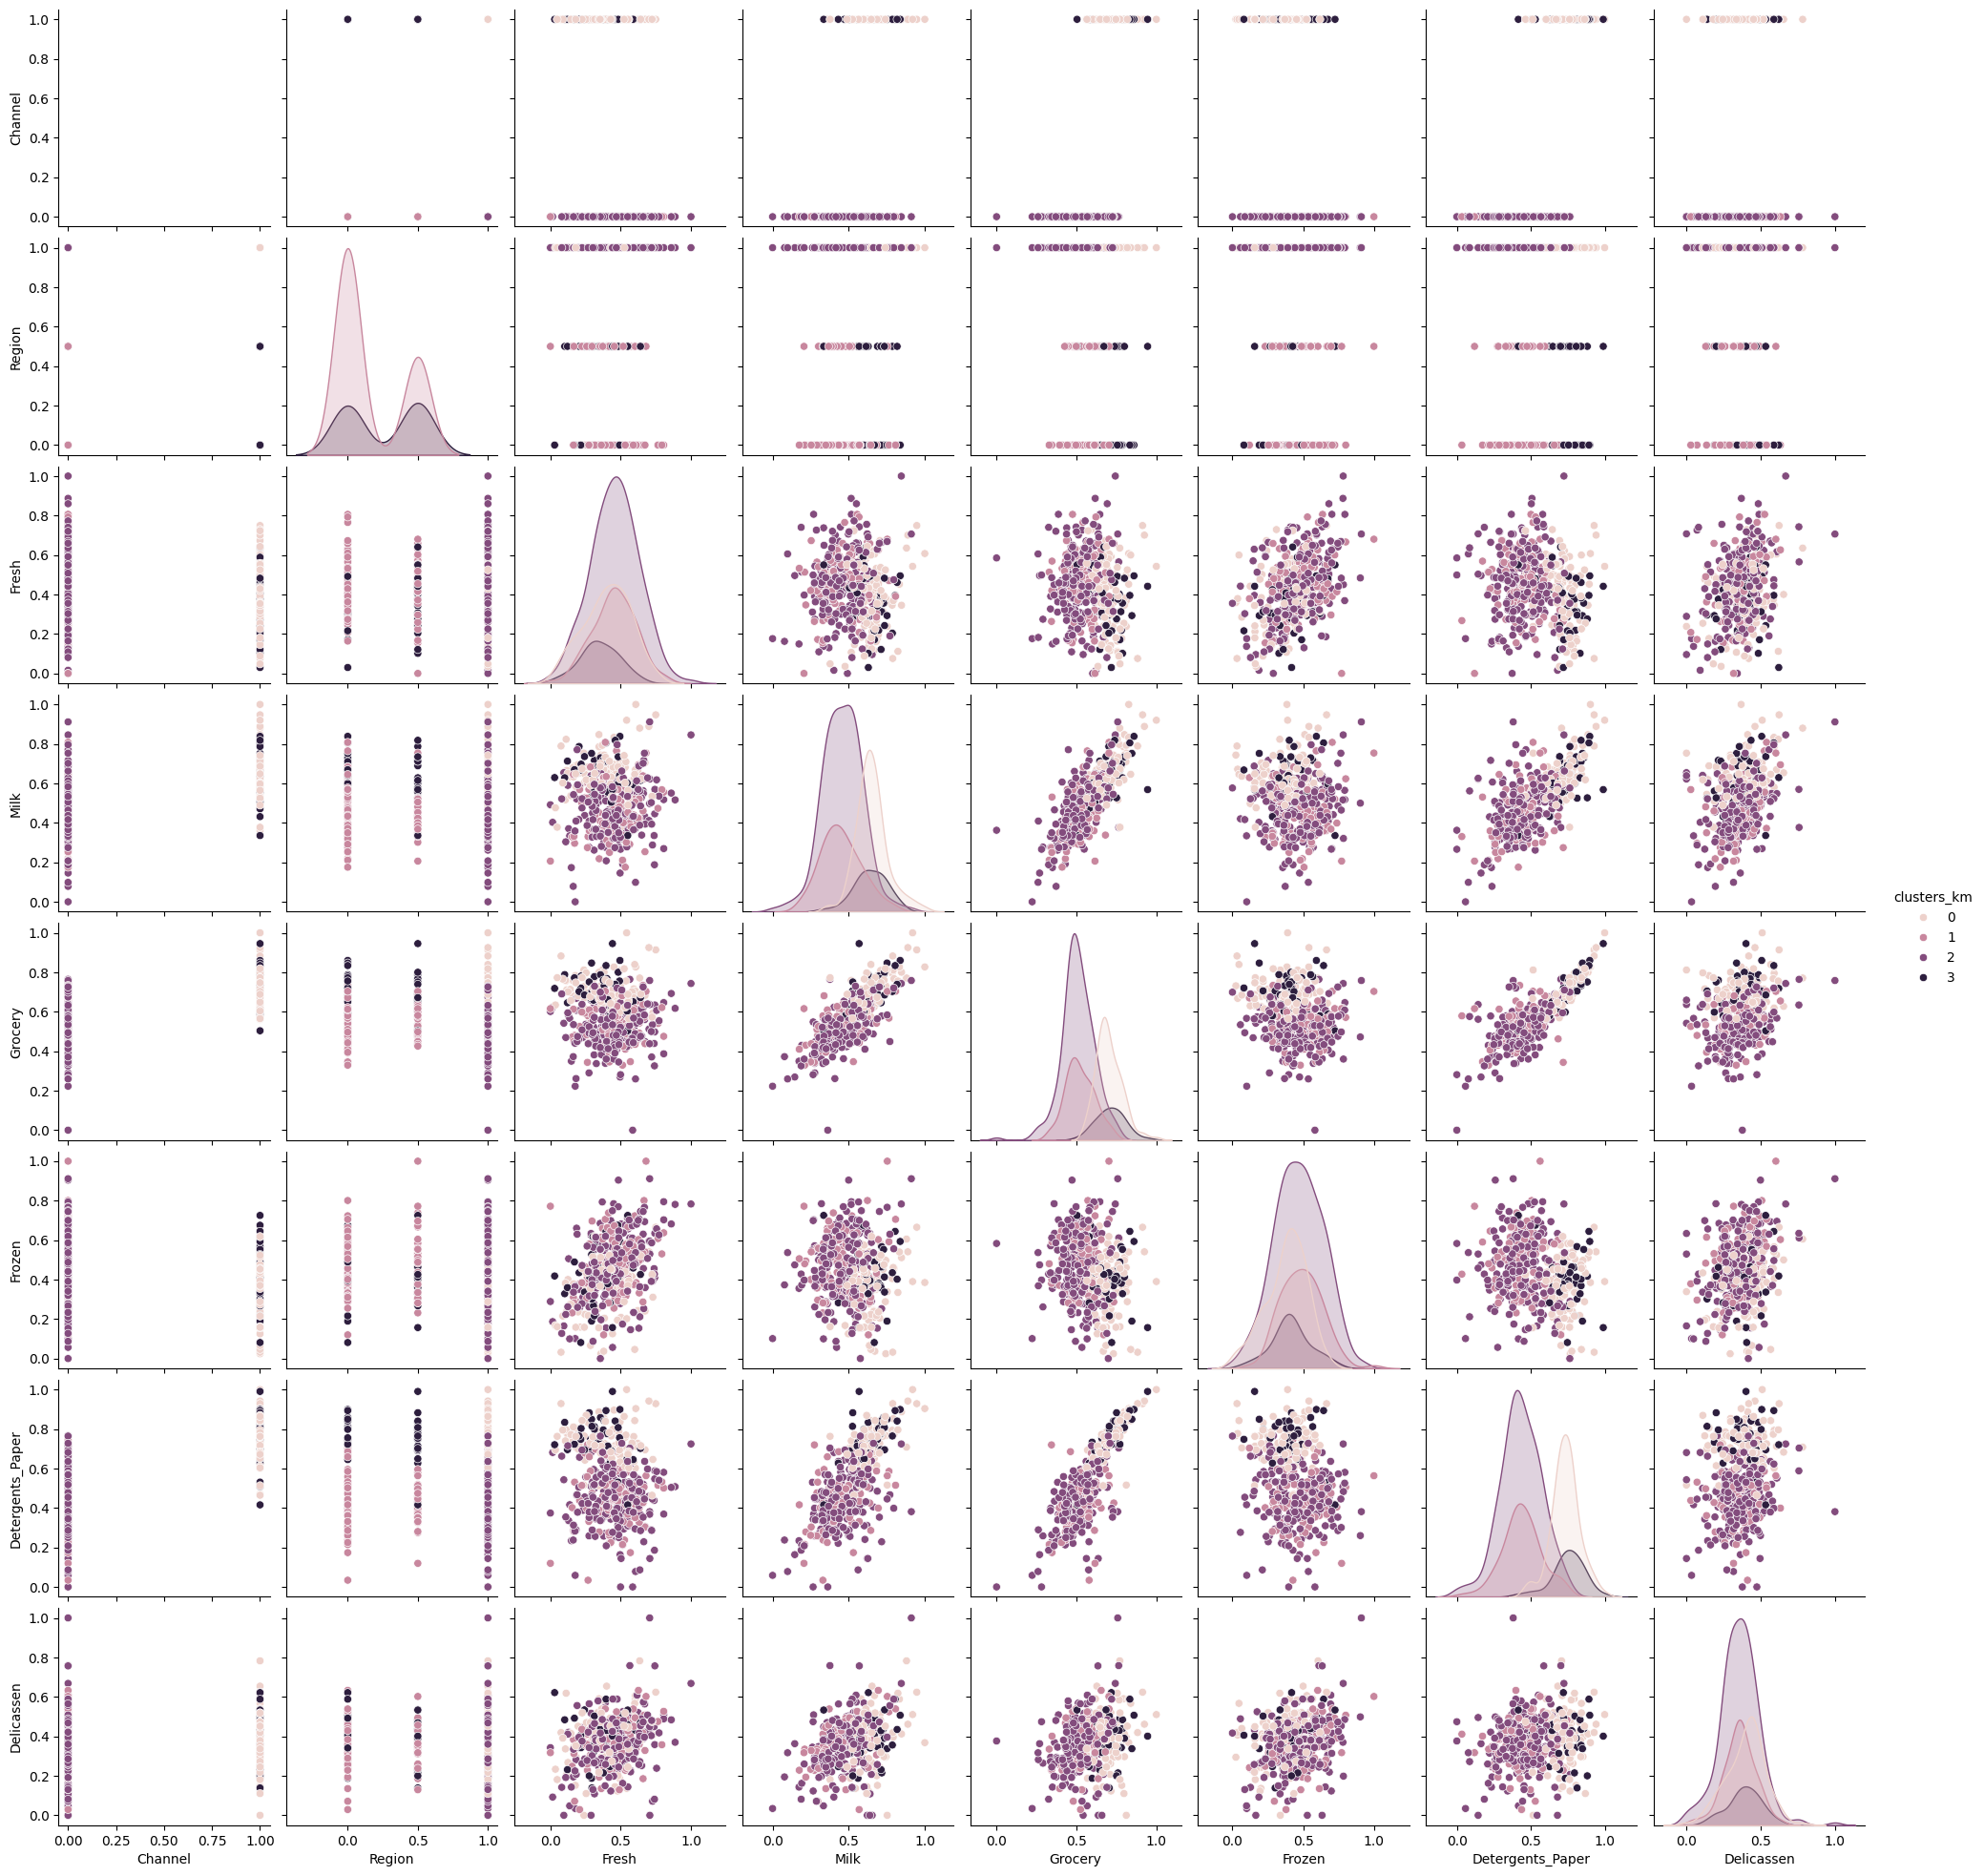

In [19]:
X['clusters_km'] = y_km
sns.pairplot(X, hue='clusters_km')

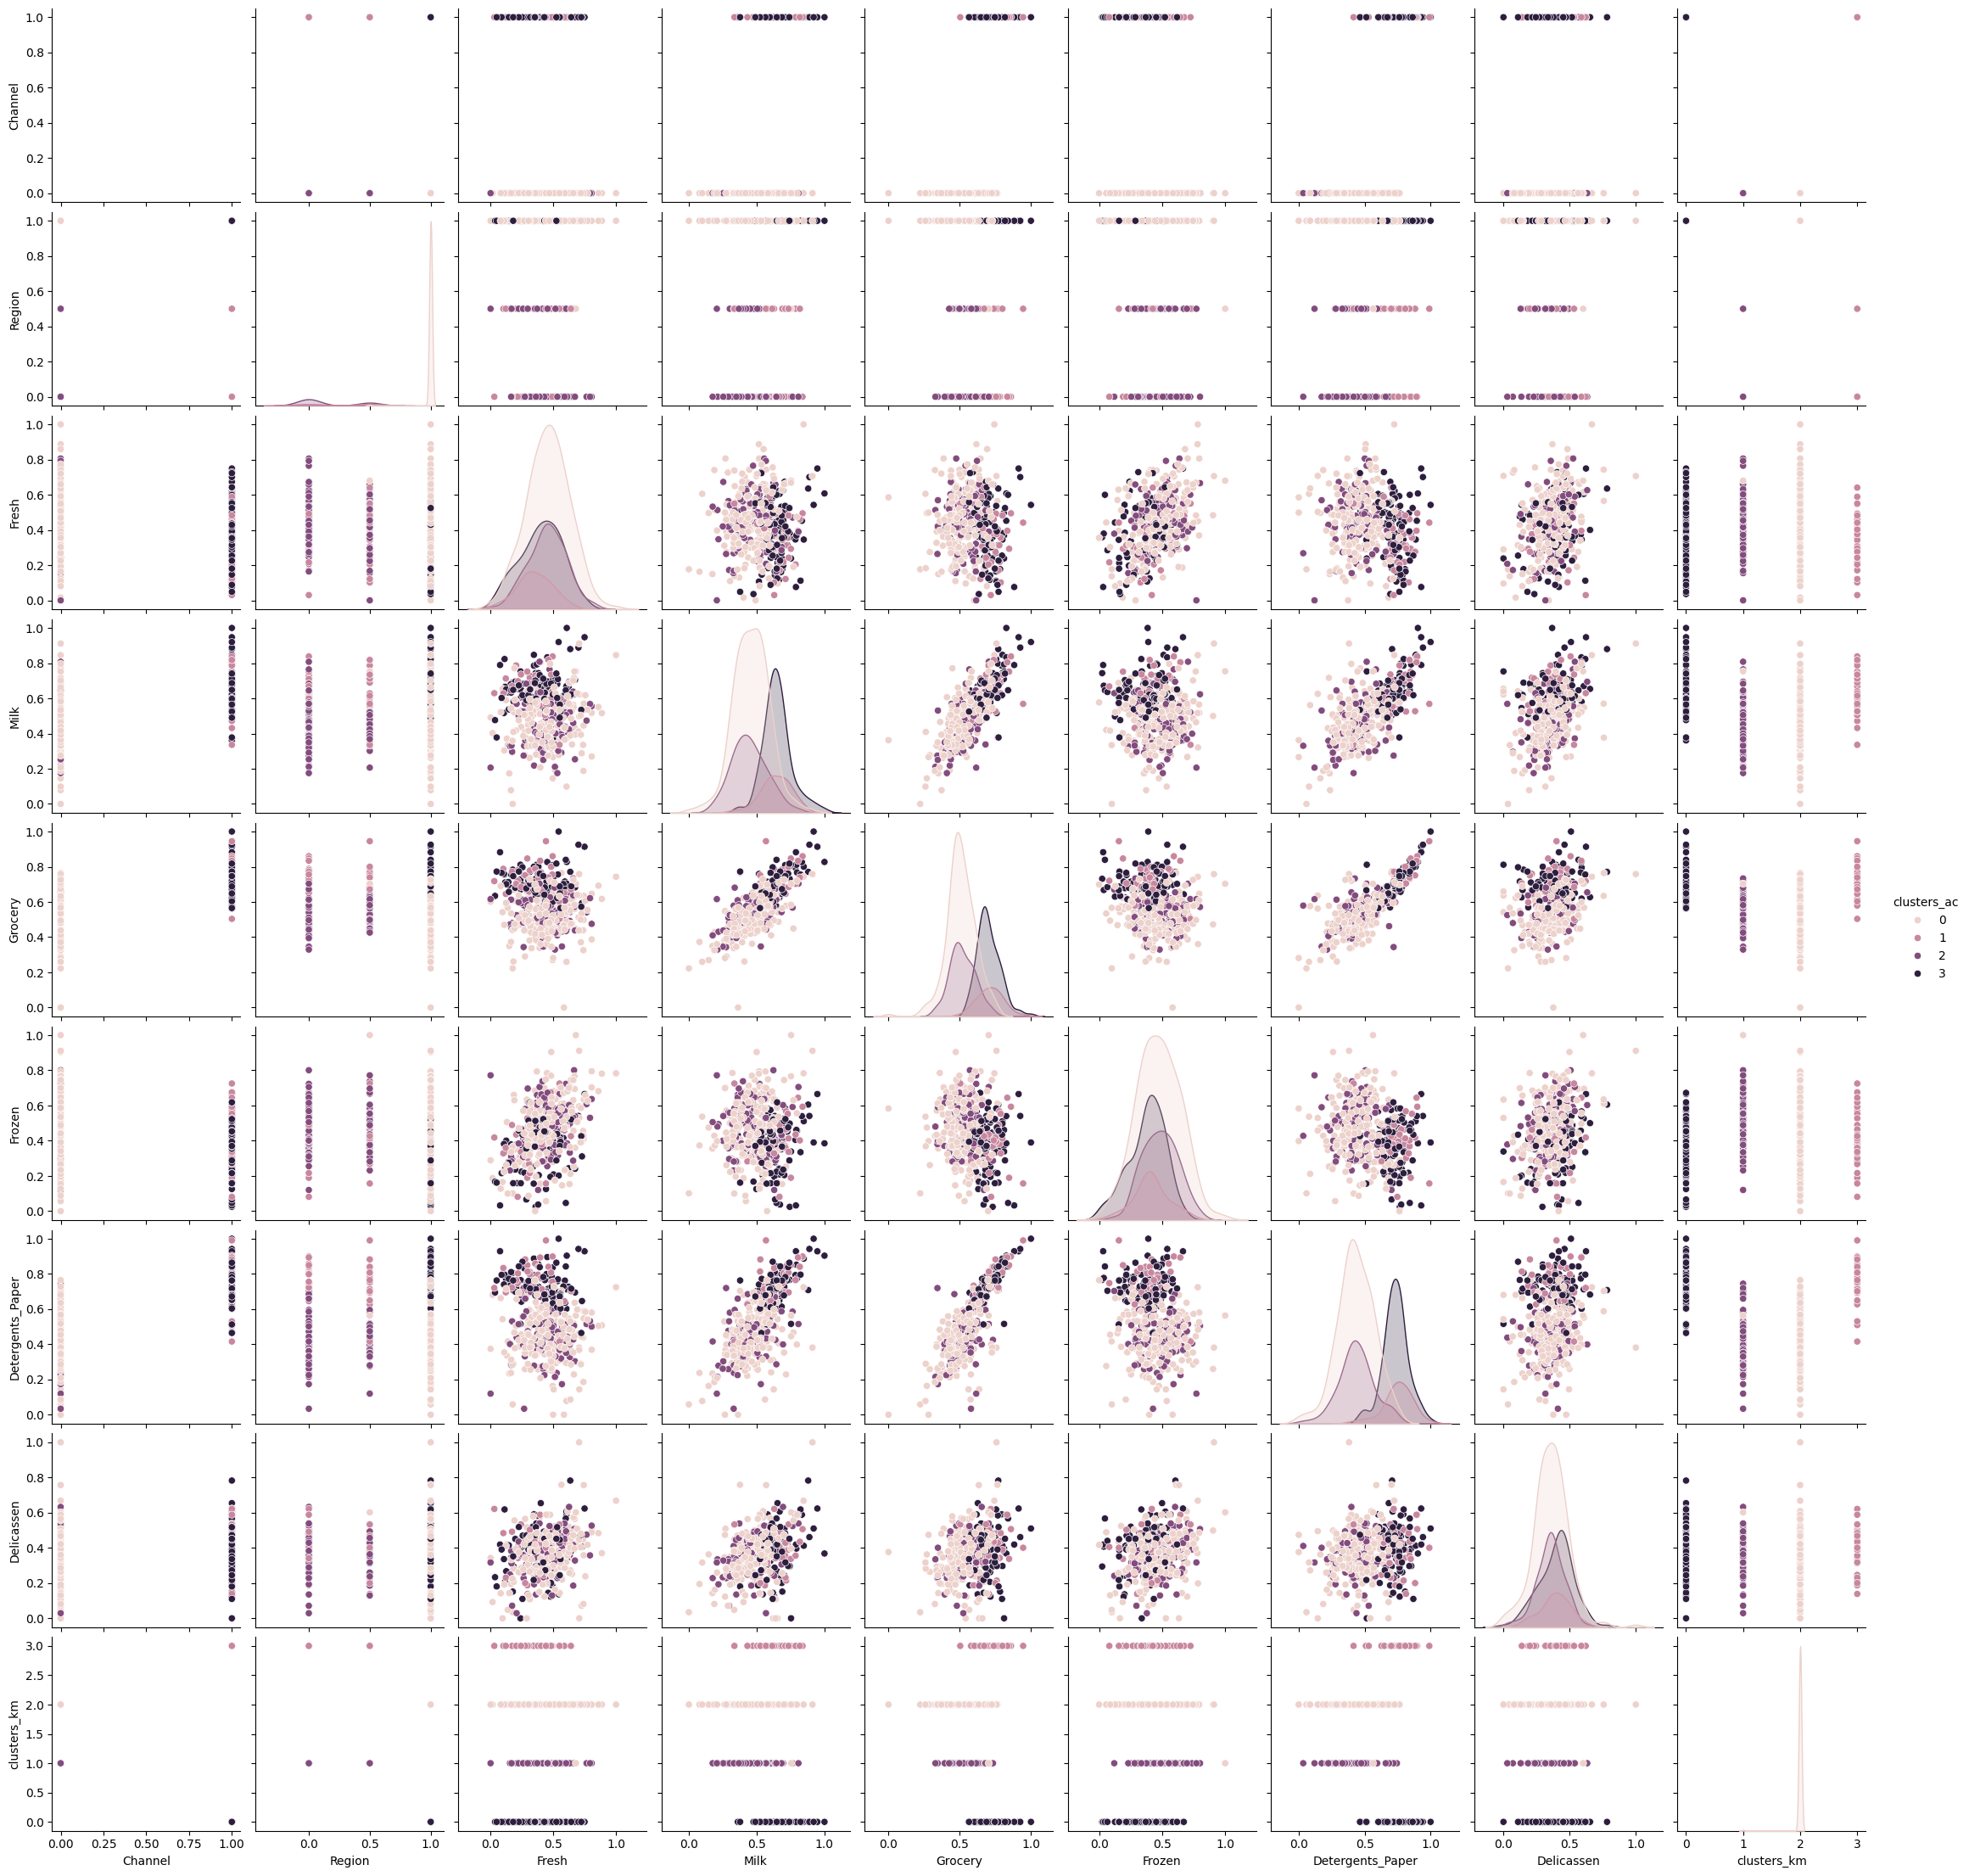

In [20]:
X['clusters_ac'] = y_ac
sns.pairplot(X, hue='clusters_ac')

### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the smaller the numbers out of the main diagona, the better the match.

For easier readability, we divide all the elements of the matrix by the sum of all the elements of the matrix, in this way, the matrix elements are normalized to 1.

In [21]:
# from sklearn.metrics import pair_confusion_matrix
# pcm = pair_confusion_matrix(y_km, y_ac)
# pcm/pcm.sum()

from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y_km, y_ac)
pcm/pcm.sum()

array([[0.66625595, 0.00218472],
       [0.00089045, 0.33066888]])

A short indicator of the match percentage can be optained as a sum of the elements of the main diagonal.

In [22]:
print(f'The percentage of match based between the two clustering schemes is {(pcm / pcm.sum()).diagonal().sum().round(4)*100}%')


The percentage of match based between the two clustering schemes is 99.69%


## DBSCAN

In [23]:
# from sklearn.cluster import DBSCAN
# db = DBSCAN()
# y_db = db.fit_predict(X)

from sklearn.cluster import DBSCAN
db = DBSCAN()
y_db = db.fit_predict(X)

In [24]:
# print(f'Default parameters - Eps={db.eps} - Min_Samples={db.min_samples}')
#print the default parameters of eps and min_samples

print(f'Eps {db.eps} min samples {db.min_samples}')

Eps 0.5 min samples 5


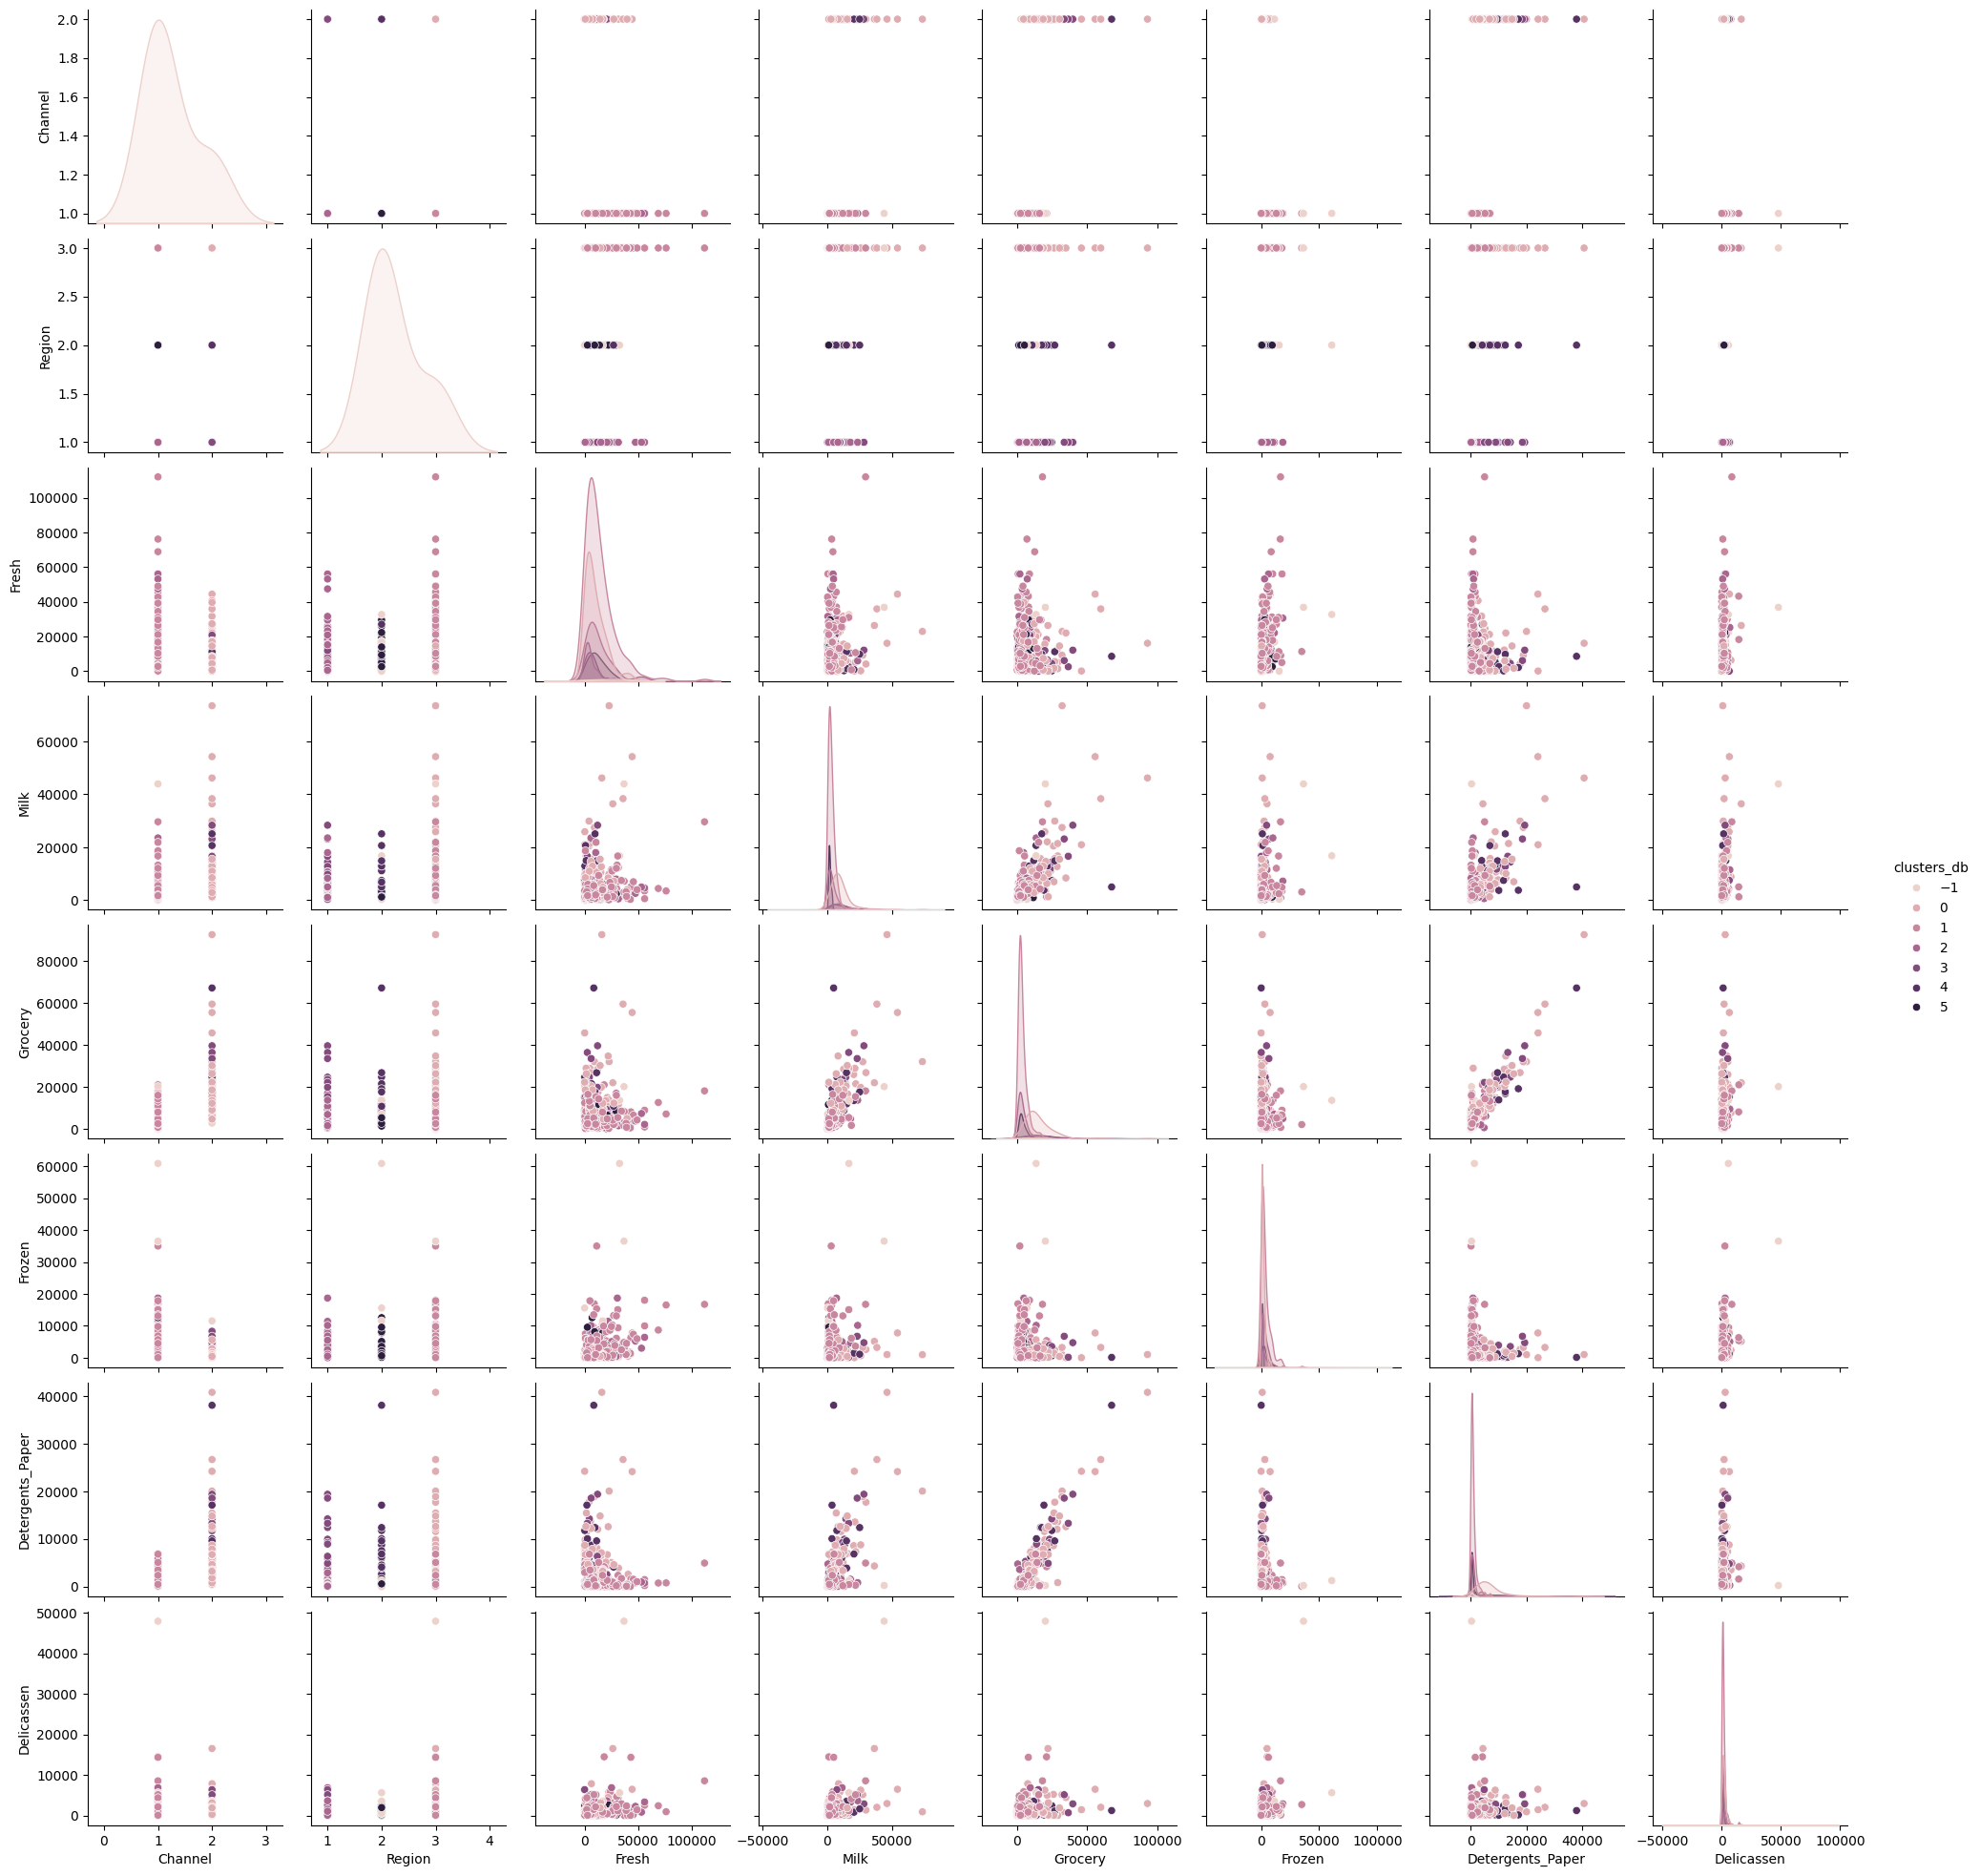

In [25]:
#since we are using default parameter I put everything in X0

X0['clusters_db'] = y_db
sns.pairplot(X0, hue='clusters_db')

Show the distribution of data in the clusters

([<matplotlib.patches.Wedge at 0x2085bb73c10>,
 [Text(1.0995514121394154, 0.031411654878687266, '-1'),
  Text(0.7609795038254311, 0.794298555177838, '0'),
  Text(-1.0959648989714355, 0.0941325672789795, '1'),
  Text(0.2872288663251914, -1.061837830532302, '2'),
  Text(0.7997116208122631, -0.7552889007113922, '3'),
  Text(0.9654468590776953, -0.5271739393189054, '4'),
  Text(1.0811002312779627, -0.2030327311808014, '5')])

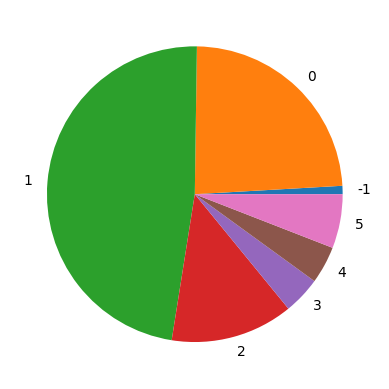

In [26]:
plt.pie(np.unique(y_db, return_counts=True)[1], labels = np.unique(y_db, return_counts=True)[0])

### 5. Find the best parameters using `ParameterGrid`

prepare the dictionary of the parameter ranges and produce the list of parameter settings to test with the function `ParameterGrid`

In [27]:
# param_grid = {
#     'eps': list(np.arange(0.001, 1, 0.005)),
#     'min_samples': list(range(2,10,1))
# }
# params = list(ParameterGrid(param_grid))


#same way we did before we have to find the best eps and min_samples

param = [{
    'eps': list(np.arange(0.001, 1, 0.005)),
    'min_samples': list(np.arange(2, 10, 1))
}]
pg = list(ParameterGrid(param))

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

`dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])`

- for each parameter setting

In [41]:
# dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
# for i in range(len(params)):
#     db = DBSCAN(**(params[i]))
#     y_db = db.fit_predict(X)
#     cluster_labels_all = np.unique(y_db)
#     cluster_labels = cluster_labels_all[cluster_labels_all != -1]
#     n_clusters = len(cluster_labels)
#     if 1 < n_clusters and n_clusters < len(y_db):
#         X_cl = X.loc[y_db!=-1,:]
#         y_db_cl = y_db[y_db!=-1]
#         silhouette = silhouette_score(X_cl,y_db_cl)
#         uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
#         dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]


results_db = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN()
    y_db = db.fit_predict(X)
    #now you need to find the cluster labels
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    #the number of clusters is given by the len of this array, ensure that there are more than one and fewer than the total number of points
    n_clusters = len(cluster_labels)
    #now you need to check the number 
    if 1<n_clusters and n_clusters>len(y_db):
        #-1 is the noise so we want to take it out, this is just filtering it out
        X_cl = X.loc[y_db != -1, :]
        y_db_cl = y_db[y_db != -1]
        silhouette = silhouette_score(X_cl, y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        results_db.loc[len(results_db)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]


        

In [33]:
results_db = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'silhouette', 'unclust%'])
for i in range(len(pg)):
    db = DBSCAN(**pg[i])
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    #filtering out the noise
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if 1<n_clusters and n_clusters>len(y_db):
        X_cl = X.loc[y_db != -1, :]
        y_db_cl = y_db[y_db != 0]
        silhouette = silhouette_score(X_cl, y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        results_db.loc[len(results_db)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]


In [31]:
sil_thr = 0.5  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
n_clu_max_thr = 5
results_db[(results_db.silhouette >= sil_thr) & (results_db.n_clusters <= n_clu_max_thr)]

TypeError: '>=' not supported between instances of 'list' and 'float'

In [34]:
#now check where the n_clusters is equal to 4
results_db[results_db.n_clusters == 4]

Empty DataFrame
Columns: [eps, min_samples, n_clusters, silhouette, unclust%]
Index: []

### 6. Observe  
- Observe visually the most promising combination of parameters reproducing the same number of clusters of the previous experiments 
- fit and predict the cluster labels and show a pairplot

In [35]:
# best = {'eps': 0.506, 'min_samples': 2}
# db=DBSCAN(**best)
# y_db = db.fit_predict(X)

best = {'eps': 0.506, 'min_samples': 2}
db = DBSCAN(**best)
y_db = db.fit_predict(X)

In [ ]:
#we are still considering n_clusters, which was k before wtf this is so inconsistent
# n_clusters = 4

#the best is going to be the default parameters
# best = {'eps': 0.506, 'min_samples': 2}
# db = DBSCAN(**best)
# y_db = db.fit_predict(X)

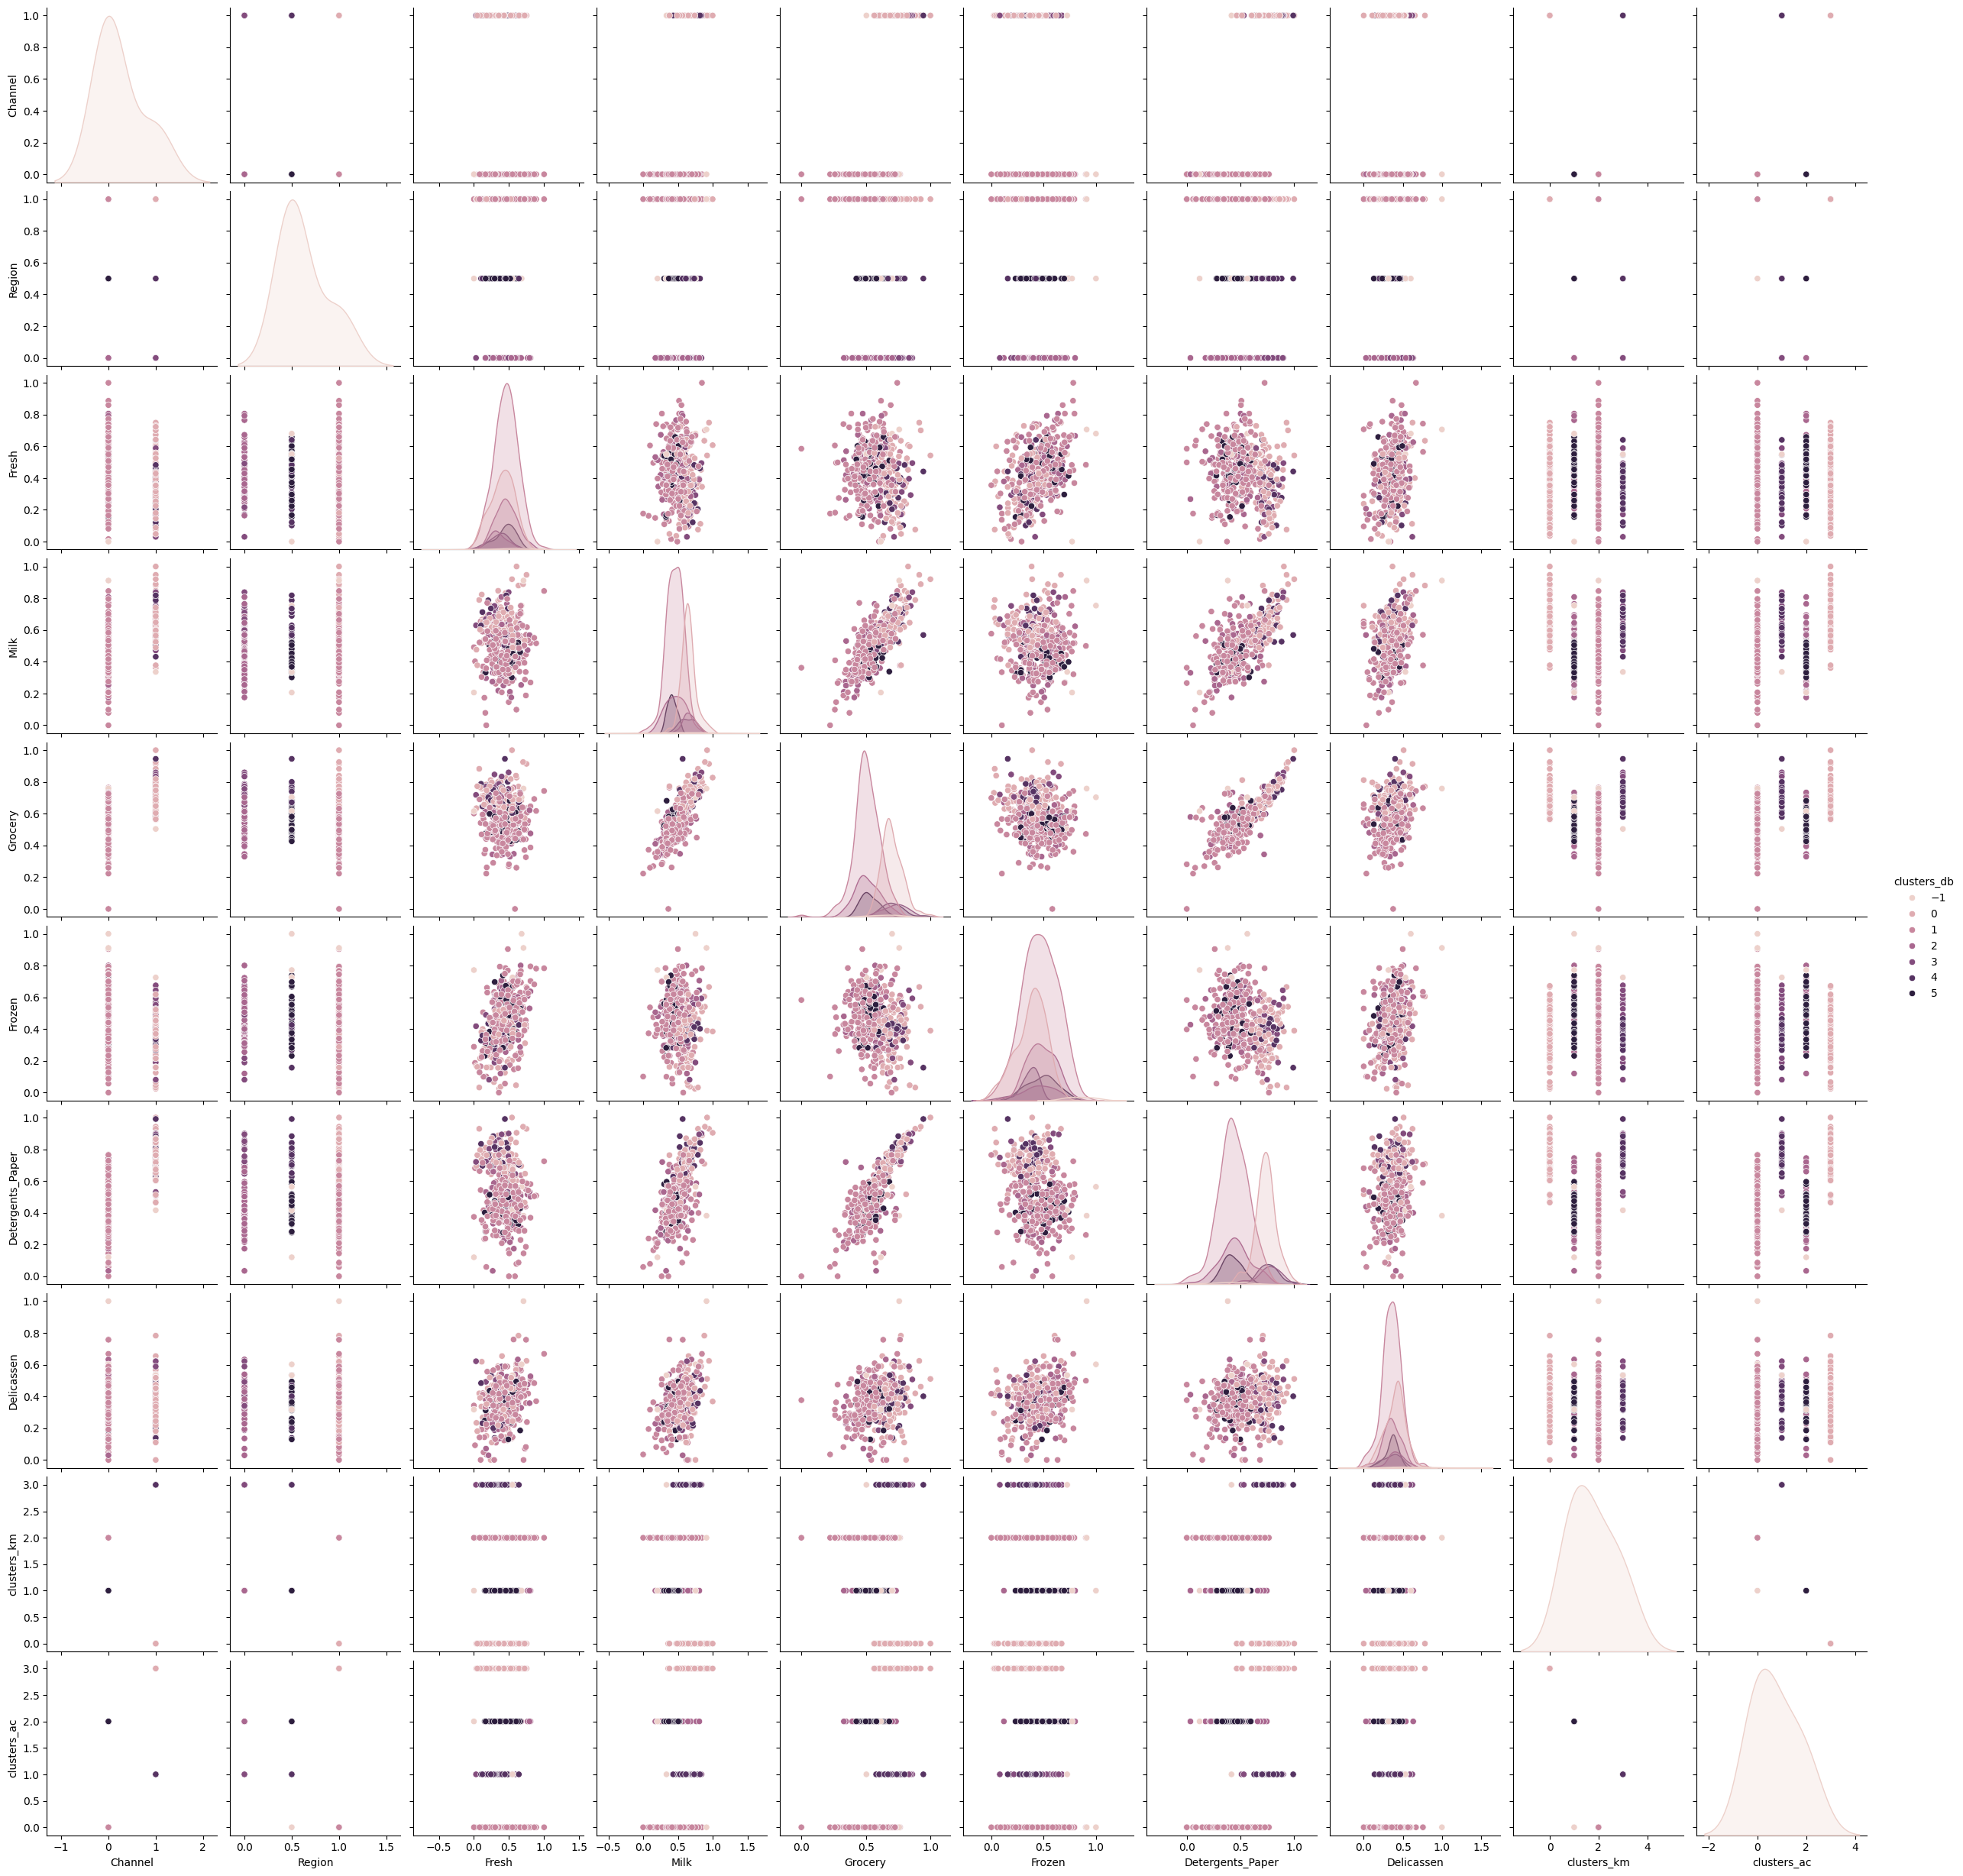

In [36]:
X['clusters_db'] = y_db
sns.pairplot(X, hue='clusters_db')

Show the cluster sizes

([<matplotlib.patches.Wedge at 0x2c99a960fd0>,
 [Text(1.0995514121394154, 0.031411654878687266, '-1'),
  Text(0.7609795038254311, 0.794298555177838, '0'),
  Text(-1.0959648989714355, 0.0941325672789795, '1'),
  Text(0.2872288663251914, -1.061837830532302, '2'),
  Text(0.7997116208122631, -0.7552889007113922, '3'),
  Text(0.9654468590776953, -0.5271739393189054, '4'),
  Text(1.0811002312779627, -0.2030327311808014, '5')])

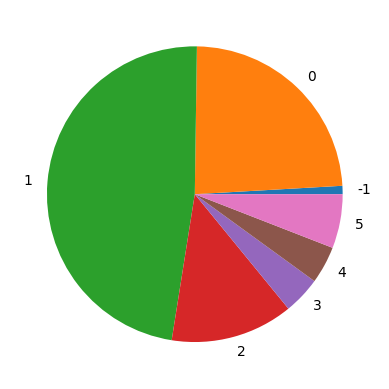

In [51]:
plt.pie(np.unique(y_db, return_counts=True)[1], labels = np.unique(y_db, return_counts=True)[0])

## Silhouette plots

Use the function `plot_silhouette` contained in the module `plot_silhouette_w_mean` (provided with the notebook) and from `sklearn.metrics` import the function `silhouette_samples` providing the silhouette score for each sample

`from plot_silhouette_w_mean import plot_silhouette  # python script provided separately`

Hint: use `help(plot_silhouette)` for the meaning of the parameters

Hint: for DBSCAN you should exclude the rows of noise

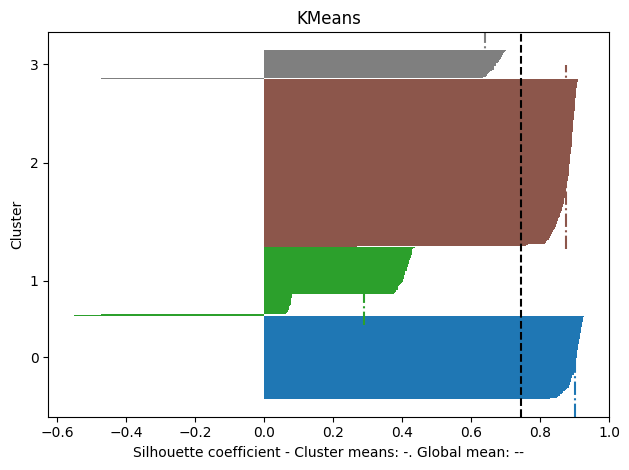

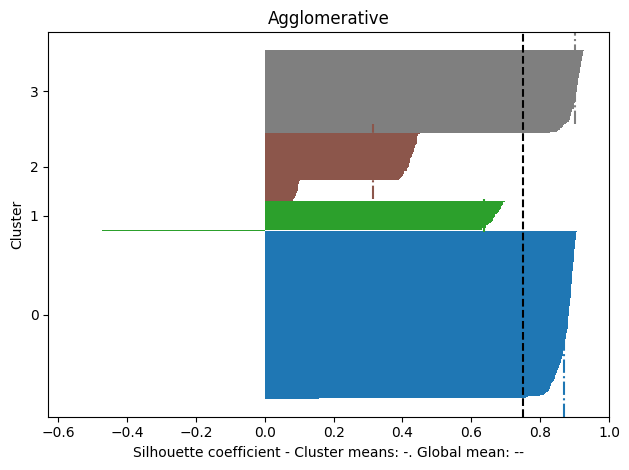

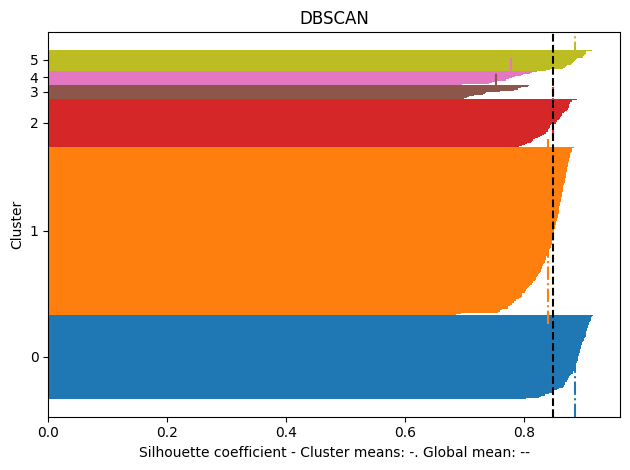

In [50]:
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately
plt.title('KMeans')
silhouette = silhouette_samples(X, y_km)
plot_silhouette(silhouette, y_km)
plt.title('Agglomerative')
silhouette = silhouette_samples(X, y_ac)
plot_silhouette(silhouette, y_ac)
plt.title("DBSCAN")
#also here we are only considering those that do not have the noise
silhouette = silhouette_samples(X.loc[y_db!=-1,:],y_db[y_db!=-1])
plot_silhouette(silhouette,y_db[y_db!=-1])

## Optional - Comparison with __boxplots__

For each of the clustering schemes show how the attribute values are distributed in the clusters

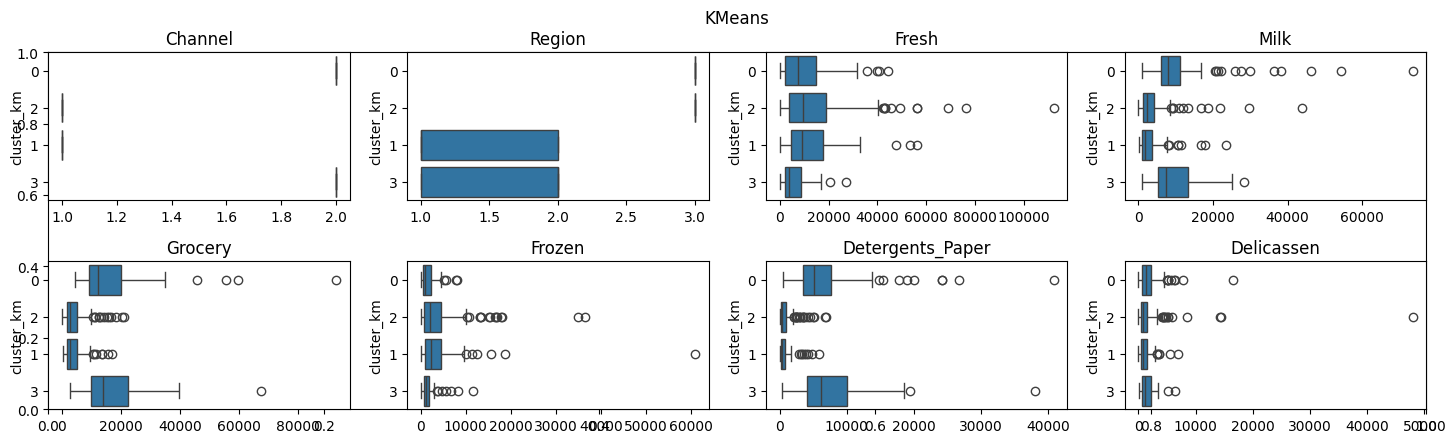

In [ ]:
# plt.figure(figsize=(15,5))
# plt.title('KMeans\n')
# pos = 1
# for i in X0.columns[0:8]:
#     plt.subplot(2, 4, pos)
#     plt.title(X0.columns[pos-1])
#     plt.tight_layout()
#     sns.boxplot(x=X0[i], y= X0['cluster_km'].astype('str')).set(xlabel=None)
#     pos += 1
# plt.show()

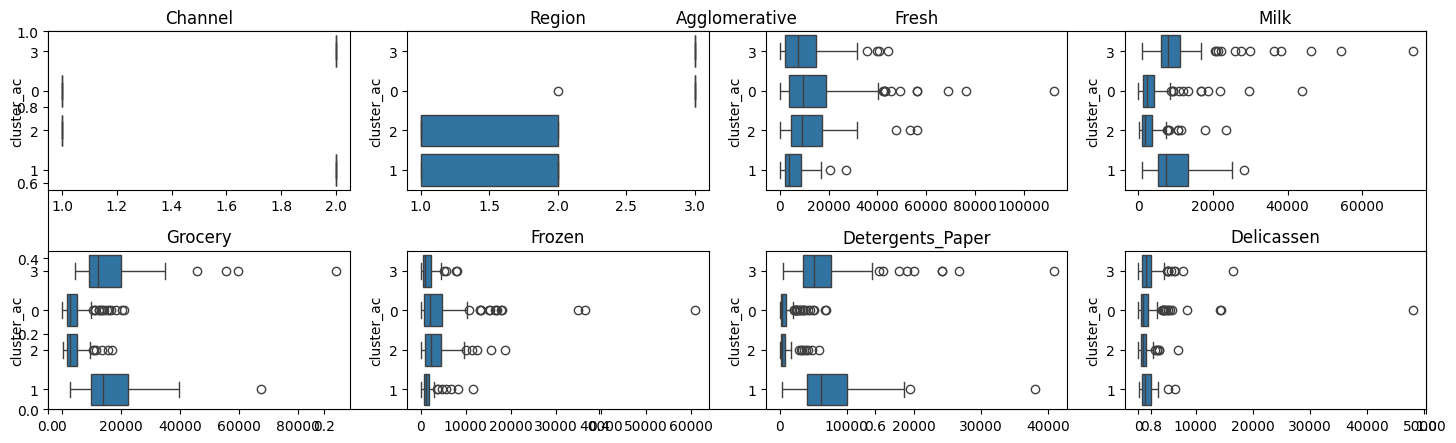

In [ ]:
# plt.figure(figsize=(15,5))
# plt.title('Agglomerative')
# pos = 1
# for i in X0.columns[0:8]:
#     plt.subplot(2, 4, pos)
#     plt.title(X0.columns[pos-1])
#     plt.tight_layout()
#     sns.boxplot(x=X0[i], y= X0['cluster_ac'].astype('str')).set(xlabel=None)
#     pos += 1
# plt.show()

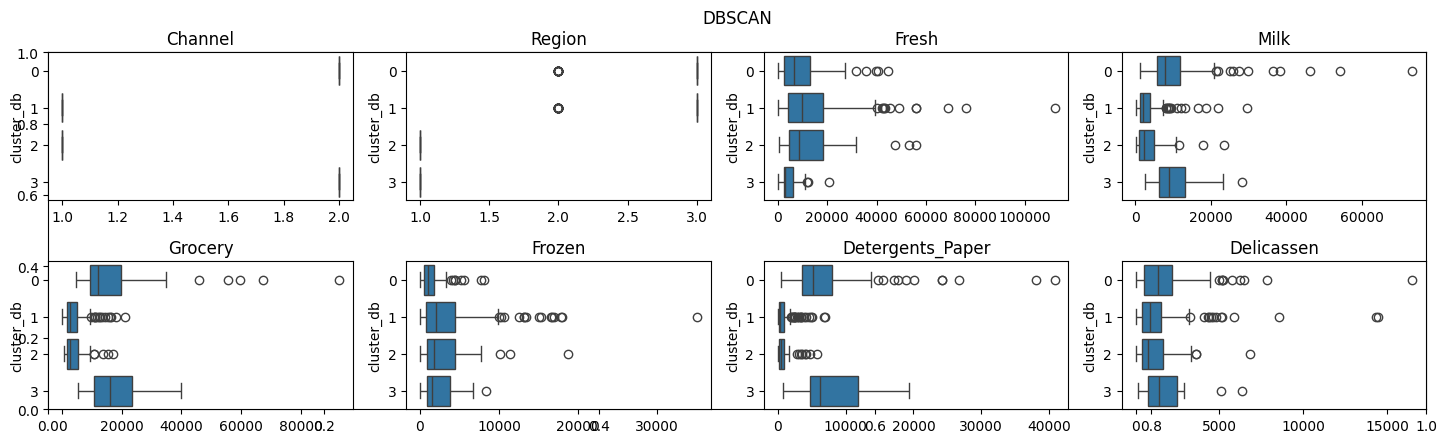

In [ ]:
# X0_c = X0.loc[X0['cluster_db']!=-1].copy()
# plt.figure(figsize=(15,5))
# plt.title('DBSCAN\n')
# pos = 1
# for i in X0.columns[0:8]:
#     plt.subplot(2, 4, pos)
#     plt.title(X0.columns[pos-1])
#     plt.tight_layout()
#     sns.boxplot(x=X0_c[i], y= X0_c['cluster_db'].astype('str')).set(xlabel=None)
#     pos += 1
# plt.show()

## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results